# Imports
we will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.

In [ ]:
import os

import re

import time

import json

import PIL.Image

import PIL.ImageFont

import PIL.ImageDraw

import numpy as np

import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50

from matplotlib import pyplot as plt

import tensorflow_datasets as tfds

from sklearn.metrics import (

    classification_report,

    accuracy_score,

    f1_score,

    roc_auc_score,

    roc_curve,

    auc,

)

from sklearn.preprocessing import label_binarize

from itertools import cycle



# Print TensorFlow version

print("Tensorflow version " + tf.__version__)




Tensorflow version 2.15.0


# Parameters
Define the batch size \\
Define the class (category) names

In [ ]:

# Constants

BATCH_SIZE = 32

classes = [

    'airplane',

    'automobile',

    'bird',

    'cat',

    'deer',

    'dog',

    'frog',

    'horse',

    'ship',

    'truck'

]


**Define some functions that will help us to create some visualizations.**

In [ ]:
# Matplotlib configuration

plt.rc('image', cmap='gray')

plt.rc('grid', linewidth=0)

plt.rc('xtick', top=False, bottom=False, labelsize='large')

plt.rc('ytick', left=False, right=False, labelsize='large')

plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')

plt.rc('text', color='a8151a')

plt.rc('figure', facecolor='F0F0F0')



# Matplotlib fonts

MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")



# Utility to display a row of digits with their predictions

def display_images(digits, predictions, labels, title):

    n = 10

    indexes = np.random.choice(len(predictions), size=n)

    n_digits = digits[indexes]

    n_predictions = predictions[indexes]

    n_predictions = n_predictions.reshape((n,))

    n_labels = labels[indexes]



    fig = plt.figure(figsize=(20, 4))

    plt.title(title)

    plt.yticks([])

    plt.xticks([])

    for i in range(10):

        ax = fig.add_subplot(1, 10, i + 1)

        class_index = n_predictions[i]

        plt.xlabel(classes[class_index])

        plt.xticks([])

        plt.yticks([])

        plt.imshow(n_digits[i])

# Utility to display training and validation curves

def plot_metrics(metric_name, title, ylim=5):

    plt.title(title)

    plt.ylim(0, ylim)

    plt.plot(history.history[metric_name], color='blue', label=metric_name)

    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)




# Loading and Preprocessing Data

CIFAR-10 dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras.

170498071/170498071 [==============================] - 11s 0us/step


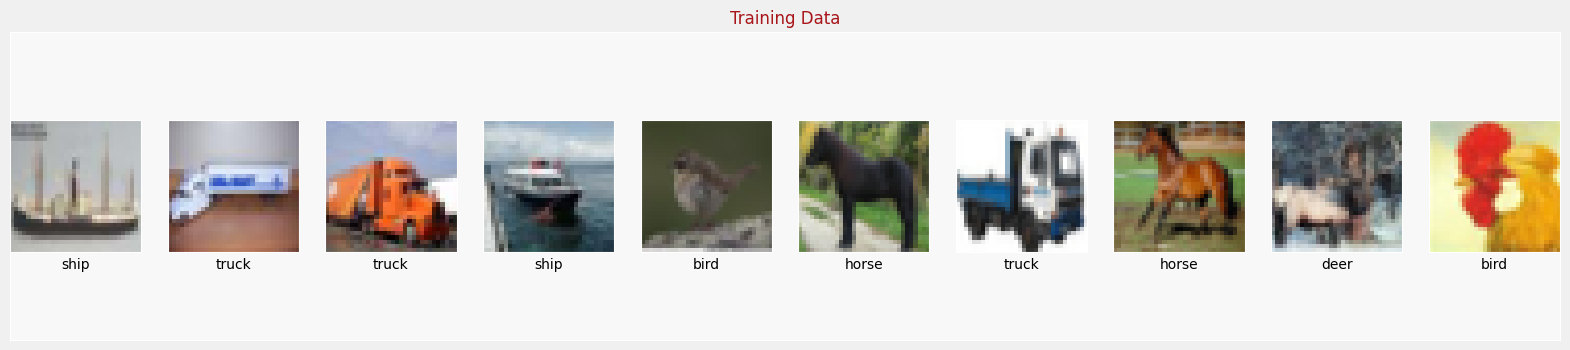

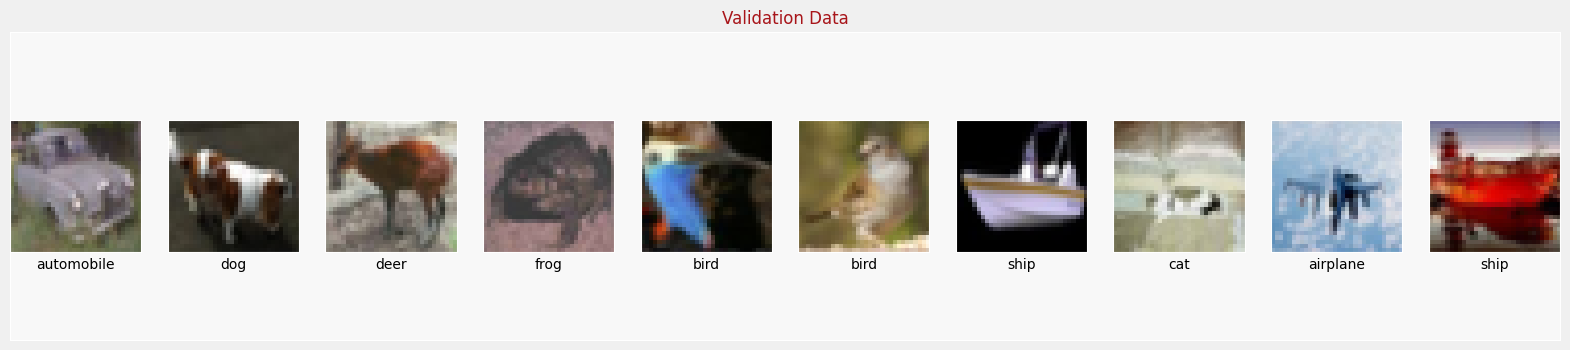

In [ ]:
# Load and preprocess data

(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()



# Visualize dataset

display_images(training_images, training_labels, training_labels, "Training Data")

display_images(validation_images, validation_labels, validation_labels, "Validation Data")


# Preprocess Dataset

Here, we'll perform normalization on images in training and validation set. \\

We'll use the function preprocess_input from the ResNet50 model in Keras.



In [ ]:
# Preprocess dataset

def preprocess_image_input(input_images):

    input_images = input_images.astype('float32')

    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)

    return output_ims



train_X = preprocess_image_input(training_images)

valid_X = preprocess_image_input(validation_images)


# Define the Network

We will be performing transfer learning on ResNet50 available in Keras.

We'll load pre-trained imagenet weights to the model.
We'll choose to retain all layers of ResNet50 along with the final classification layers.

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [ ]:
# Force the model to run on GPU
with tf.device('/device:GPU:0'):


    def feature_extractor(inputs):
        feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                                    include_top=False,
                                                    weights='imagenet')(inputs)
        return feature_extractor


    def classifier(inputs):
        x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(1024, activation="relu")(x)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
        return x


    def final_model(inputs):
        resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
        resnet_feature_extractor = feature_extractor(resize)
        classification_output = classifier(resnet_feature_extractor)
        return classification_output


    def define_compile_model():
        inputs = tf.keras.layers.Input(shape=(32,32,3))
        classification_output = final_model(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=classification_output)
        model.compile(optimizer='SGD',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        return model

    model = define_compile_model()
    model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

# Train the model

In [ ]:
EPOCHS = 5
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/5
782/782 [==============================] - 580s 706ms/step - loss: 0.3981 - accuracy: 0.8714 - val_loss: 0.1950 - val_accuracy: 0.9349
Epoch 2/5
782/782 [==============================] - 534s 683ms/step - loss: 0.1029 - accuracy: 0.9669 - val_loss: 0.1682 - val_accuracy: 0.9458
Epoch 3/5
618/782 [======================>.......] - ETA: 1:46 - loss: 0.0352 - accuracy: 0.9900

# Plot Loss and Accuracy Curves
Plot the loss (in blue) and validation loss (in green).

In [ ]:
# Plot loss and accuracy curves

def plot_learning_curves(history):

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)

    plt.plot(history.history['accuracy'], label='Training Accuracy')

    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    plt.legend(loc='lower right')

    plt.title('Training and Validation Accuracy')



    plt.subplot(1, 2, 2)

    plt.plot(history.history['loss'], label='Training Loss')

    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.legend(loc='upper right')

    plt.title('Training and Validation Loss')

    plt.show()



plot_learning_curves(history)



# Visualize predictions
We can take a look at the predictions on the validation set.

In [ ]:
# Visualize predictions

probabilities = model.predict(valid_X, batch_size=64)

probabilities = np.argmax(probabilities, axis=1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")


# **Evaluation**

In [ ]:
# Evaluation

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



true_classes = validation_labels.ravel()

predicted_classes = probabilities



# 1. Classification report

print("Classification Report:")

print(classification_report(true_classes, predicted_classes, target_names=class_names))



# 2. Accuracy

acc = accuracy_score(true_classes, predicted_classes)

print(f"Accuracy: {acc:.4f}")



# 3. F1 Score

f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"F1 Score: {f1:.4f}")



# Compute ROC AUC Score and ROC AUC Curve

predicted_probs = model.predict(valid_X, batch_size=64)

true_binaries = label_binarize(true_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])



# 4. ROC AUC Score

roc_auc = roc_auc_score(true_binaries, predicted_probs, average="macro", multi_class="ovr")

print(f"ROC AUC Score: {roc_auc:.4f}")



# 5. ROC AUC Curve (Multi-Class)

n_classes = len(class_names)

fpr = {}

tpr = {}

roc_auc_score_class = {}



for i in range(n_classes):

    fpr[i], tpr[i], _ = roc_curve(true_binaries[:, i], predicted_probs[:, i])

    roc_auc_score_class[i] = auc(fpr[i], tpr[i])



# Plot ROC AUC Curve

plt.figure(figsize=(12, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'gray', 'brown', 'deeppink'])

for i, color in zip(range(n_classes), colors):

    plt.plot(fpr[i], tpr[i], color=color, lw=2,

             label='ROC curve of {0} (area = {1:0.2f})'

             ''.format(class_names[i], roc_auc_score_class[i]))



plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Multi-class ROC AUC Curve')

plt.legend(loc="lower right")

plt.show()



# **Saving the model**

In [ ]:
model.save('model_resnet_cifar.h5')